# Risk Factor Clinical Classifier

This classifier takes patient answers to the Lung Space clinical survey and predicts the chance of cancer.

In [1]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

df = pd.read_csv('../data/lungspace/package-nlst-1193.2024-02-20/participant_d040722.csv')

# Breakdown of positive and negative sample size
print("positive: ", len(df['lung_cancer'].loc[df['lung_cancer'] == 1].to_list()), " negative: ", len(df['lung_cancer'].loc[df['lung_cancer'] == 0].to_list()))


/tmp/ipykernel_2201/547569613.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


positive:  2058  negative:  51394


/tmp/ipykernel_2201/547569613.py:8: DtypeWarning: Columns (239,240,348) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/lungspace/package-nlst-1193.2024-02-20/participant_d040722.csv')


In [2]:
# List of features
print(df.columns.to_list())

dataset_columns = ['age', 'weight', 'height', "cigar","cigsmok","pipe","pkyr","smokeage","smokeday","smokelive","smokework","smokeyr","num_screens", "lung_cancer"]

df = df[dataset_columns]
df = df.dropna()

# lung_cancer_col = df['lung_cancer']

# df = normalize(df, axis=0)
# df = pd.DataFrame(df, columns=dataset_columns)

# df['lung_cancer'] = lung_cancer_col
print(df)

print(df.loc[df["lung_cancer"] != 0]['lung_cancer'])


['cen', 'dataset_version', 'elig', 'ineligible', 'pid', 'rndgroup', 'study', 'age', 'educat', 'ethnic', 'gender', 'has_bq', 'height', 'marital', 'race', 'weight', 'age_quit', 'cigar', 'cigsmok', 'pipe', 'pkyr', 'smokeage', 'smokeday', 'smokelive', 'smokework', 'smokeyr', 'last_screen_studyyr', 'num_screens', 'scr_days0', 'scr_days1', 'scr_days2', 'scr_group', 'scr_iso0', 'scr_iso1', 'scr_iso2', 'scr_lat0', 'scr_lat1', 'scr_lat2', 'scr_res0', 'scr_res1', 'scr_res2', 'biop0', 'biop1', 'biop2', 'bioplc', 'invas0', 'invas1', 'invas2', 'invaslc', 'medcomp0', 'medcomp1', 'medcomp2', 'medcomplc', 'mra_stat0', 'mra_stat1', 'mra_stat2', 'no_proc_reas0', 'no_proc_reas1', 'no_proc_reas2', 'proc0', 'proc1', 'proc2', 'proclc', 'can_scr', 'canc_free_days', 'canc_rpt_link', 'canc_rpt_source', 'cancyr', 'candx_days', 'conflc', 'de_grade', 'de_stag', 'de_stag_7thed', 'de_type', 'histology_cat', 'lesionsize', 'loccar', 'loclhil', 'loclin', 'locllow', 'loclmsb', 'loclup', 'locmed', 'locoth', 'locrhil', '

## Define models

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    # "RBF SVM",
    # "Gaussian Process",
    "Decision Tree",
    # "Random Forest",
    # "Neural Net",
    # "AdaBoost",
    "Naive Bayes",
    # "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    # SVC(gamma=2, C=1, random_state=42),
    # GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    # RandomForestClassifier(
    #     max_depth=5, n_estimators=10, max_features=1, random_state=42
    # ),
    # MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    # AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    # QuadraticDiscriminantAnalysis(),
]

print(df)

X = df[['age', 'weight', 'height', "cigar","cigsmok","pipe","pkyr","smokeage","smokeday","smokelive","smokework","smokeyr","num_screens"]]
y = df[['lung_cancer']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

print(X_train)
print(X_test)
print(y_train)
print(y_test)


       age  weight  height  cigar  cigsmok  pipe    pkyr  smokeage  smokeday  \
0       70   134.0    70.0    1.0        1   1.0   99.00       4.0        30   
1       66   175.0    68.0    0.0        1   0.0   52.00      14.0        20   
2       64   180.0    70.0    0.0        1   0.0   66.00      20.0        30   
3       60   205.0    70.0    0.0        0   1.0   34.00      22.0        40   
4       64   220.0    67.0    0.0        0   0.0   92.00      15.0        40   
...    ...     ...     ...    ...      ...   ...     ...       ...       ...   
53447   73   206.0    64.0    0.0        1   0.0  120.00       6.0        40   
53448   66   175.0    71.0    0.0        1   0.0   50.00      16.0        20   
53449   56   172.0    72.0    1.0        0   0.0   38.00      18.0        20   
53450   69   210.0    68.0    0.0        0   0.0   41.25       9.0        15   
53451   57   220.0    69.0    0.0        1   0.0   50.00      17.0        25   

       smokelive  smokework  smokeyr  n

## Test models and plot confusion matrices

The goal is to minimize the number of false negative predictions.

/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model:  Nearest Neighbors  score:  0.9550652816163157


/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model:  Linear SVM  score:  0.9614028399885638
Model:  Decision Tree  score:  0.9608786810254455
Model:  Naive Bayes  score:  0.9269036500524159


/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


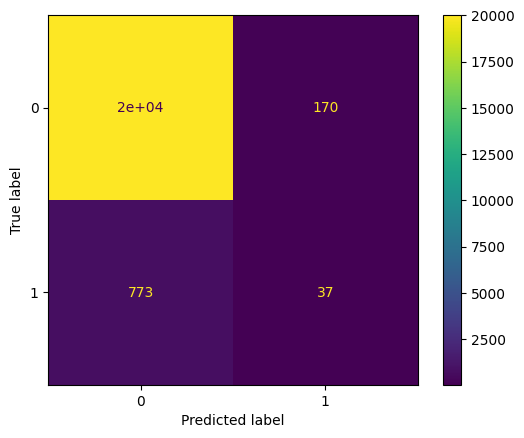

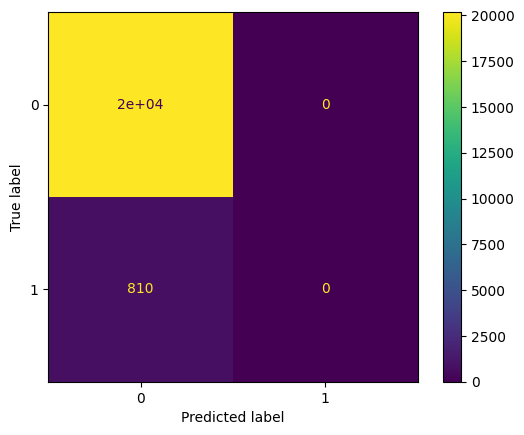

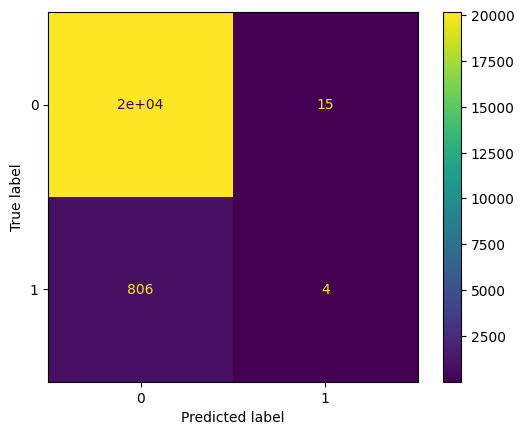

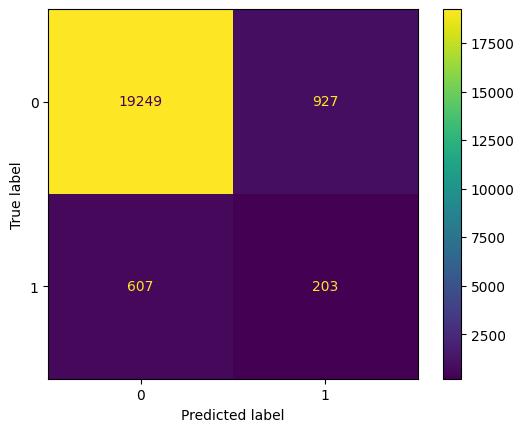

In [4]:
for name, clf in zip(names, classifiers):
  clf = make_pipeline(StandardScaler(), clf)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  score = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
  disp.plot()
  # score = clf.score(X_test, y_test)
  print("Model: ", name, " score: ", score)


## Get confidence of each prediction with `predict_proba()`

In [5]:
# model = SVC(kernel="linear", C=0.025, random_state=42, probability=True)
model = GaussianNB()

model = make_pipeline(StandardScaler(), model)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

print(y_pred_prob)


[[0.99571561 0.00428439]
 [0.98265187 0.01734813]
 [0.99512919 0.00487081]
 ...
 [0.99089519 0.00910481]
 [0.99455889 0.00544111]
 [0.94346535 0.05653465]]


/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Compare compare the probabilities of false positives and false negatives to true positives and true negatives

In [6]:
true_negative_probs = []
false_negative_probs = []
true_positive_probs = []
false_positive_probs = []

y_pred_list = y_pred.tolist()
y_pred_prob_list = y_pred_prob.tolist()
y_test_list = y_test['lung_cancer'].tolist()

for i in range(len(y_test)):
  # true negative
  if y_pred_list[i] == 0 and y_test_list[i] == 0:
    true_negative_probs.append(y_pred_prob_list[i][0])
  # false negative
  elif y_pred_list[i] == 0 and y_test_list[i] == 1:
    false_negative_probs.append(y_pred_prob_list[i][0])
  # true positive
  elif y_pred_list[i] == 1 and y_test_list[i] == 1:
    true_positive_probs.append(y_pred_prob_list[i][1])
  # false positive
  else:
    false_positive_probs.append(y_pred_prob_list[i][1])


## Plot the probabilities that led to the different predictions. 

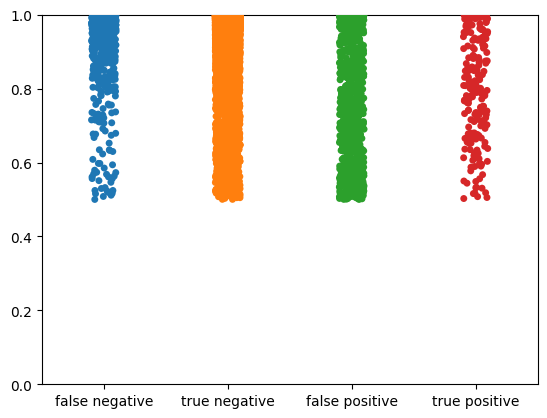

In [7]:
data = {'false negative': false_negative_probs,
               'true negative': true_negative_probs,
               'false positive': false_positive_probs,
               'true positive': true_positive_probs,
              }
cols = ['false negative', 'true negative', 'false positive', 'true positive']

df = pd.DataFrame.from_dict(
    data=dict(data),
    orient='index',
).T

fig, ax = plt.subplots()

ax = sns.stripplot(data=df)
ax.set_ylim(0, 1)

# sns.stripplot(ax = ax,
#               data = data,
#               x = 'probability',
#               y = 'predictions')

plt.show()
